# Parallel processing of a stack of data stored in HDF5 with multi-threading

This tutorial explains how it is possible to treat in parallel a large HDF5 dataset which does not fit into the computer memory.

For this tutorial, a very recent version of pyFAI is needed, newer then summer 2022. It demonstrates features wich will only be available in release 0.22.

This tutorial expains how to take benefit from Multithreading. This framework is not very popular in the Python world due to the GIL, but properly writted C-code which does release the GIL can be very fast, sometimes as fast as GPU code (on large computers).

Credits:

* Thomas Vincent (ESRF) for the parallel decompression of HDF5 chunks and the Jupyter-slurm
* Pierre Paleo (ESRF) for struggling with this kind of stuff with GPUs
* Jon Wright (ESRF) for the CSC integrator, while implemented in serial is multithreading friendly
* The French-CRG for providing a manycore computer (2 x 32-core AMD EPYC 75F3)

Nota: No GPU is needed for this tutorial !

In [1]:
%matplotlib inline

In [2]:
import sys, os, collections, struct, time
import numpy, pyFAI
import h5py, hdf5plugin
from queue import Queue
import threading
import bitshuffle
import multiprocessing
from matplotlib.pyplot import subplots
start_time = time.time()
Item = collections.namedtuple("Item", "index data")
# Ensure OpenMP is disabled
# os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
nbthreads=multiprocessing.cpu_count()
print(f"Working with {nbthreads} threads but OpenMP needs to be disabled !")

Working with 64 threads but OpenMP needs to be disabled !


In [4]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   48 bits physical, 48 bits virtual
CPU(s):                          64
On-line CPU(s) list:             0-63
Thread(s) per core:              1
Core(s) per socket:              32
Socket(s):                       2
NUMA node(s):                    2
Vendor ID:                       AuthenticAMD
CPU family:                      25
Model:                           1
Model name:                      AMD EPYC 75F3 32-Core Processor
Stepping:                        1
Frequency boost:                 enabled
CPU MHz:                         1495.945
CPU max MHz:                     2950.0000
CPU min MHz:                     1500.0000
BogoMIPS:                        5888.80
Virtualization:                  AMD-V
L1d cache:                       2 MiB
L1i cache:                       2 MiB
L2 cache:                        32 MiB

## Setup the enviroment:

This is a purely virtual experiment, we will use an Eiger 4M detector with data integrated over 1000 bins. Those parameters can be tuned.

Random data are generated, to keep this file fairly small, it is generated with small numbers which compress nicely. The speed of the drive where you will put the file is likely to have a huge impact !

In [5]:
det = pyFAI.detector_factory("eiger_4M")
shape = det.shape
dtype = numpy.dtype("uint32")
filename = "/tmp/big.h5"
nbins = 1000
cmp = hdf5plugin.Bitshuffle()
hdf5plugin.config

HDF5PluginBuildOptions(openmp=False, native=False, sse2=True, avx2=False, cpp11=True, filter_file_extension='.so')

In [6]:
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
print(f"Number of frames the computer can host in memory: {mem_bytes/(numpy.prod(shape)*dtype.itemsize):.3f}")
if os.environ.get('SLURM_MEM_PER_NODE'):
    print(f"Number of frames the computer can host in memory with SLURM restrictions: {int(os.environ['SLURM_MEM_PER_NODE'])*(1<<20)/(numpy.prod(shape)*dtype.itemsize):.3f}")

Number of frames the computer can host in memory: 30127.704
Number of frames the computer can host in memory with SLURM restrictions: 3829.928


In [7]:
#The computer being limited to 64G of RAM, the number of frames actually possible is 3800.
nbframes = 4096 # slightly larger than the maximum achievable ! Such a dataset should not host in memory.

In [8]:
#Prepare a frame with little count so that it compresses well
geo = {"detector": det, 
       "wavelength": 1e-10, 
       "rot3":0} #work around a bug https://github.com/silx-kit/pyFAI/pull/1749
ai = pyFAI.load(geo)
q = numpy.arange(15)
img = ai.calcfrom1d(q, 100/(1+q*q))
frame = numpy.random.poisson(img).astype(dtype)

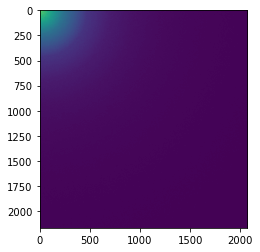

In [9]:
# display the image
fig,ax = subplots()
ax.imshow(frame)

In [10]:
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image")
for algo in ("histogram", "csc", "csr"):
    print(f"Using algorithm {algo}:", end=" ")
    %timeit ai.integrate1d(img, nbins, method=("full", algo, "cython"))

Performances of the different algorithms for azimuthal integration of Eiger 4M image
Using algorithm histogram: 430 ms ± 9.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csc: 38.3 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csr: 63 ms ± 7.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Note:** The full pixel splitting is time consuming and handicaps the histogram algorithm while both sparse-matrix methods are much faster since they cache this calculation in the sparse matrix.

The compared performances of sparse-matrix methods is rather surprizing since the CSC algorithm, single threaded, is faster than the CSR which runs in parallel over 2x32 cores.
This result is the combination of two facotors:
1. The computer is built with two processors/sockets controling each its own memory. We call this a **Non Uniform Memory Access** computer and can be checked with `numactrl --hardware`. The CSR matrix multiplication will dispatch work on both processors and thus, needs to transfer part of the image from one NUMA subsystem to the other, which is slow (32/10 x slower compared to a single-socket access). 
2. The very large cache of this processor: 512MB are reported by `lscpu`, but a more precise tool, `lstopo` describes them as 32MB of L3 cache shared between 4 cores. This very large cache allows the complete frame and the sparse matrix to be pre-fetched which is a great advantage for the CSC algorithm.

Running the very same benchmark on an Intel 2-socket server would remove the point 2, while running on a singe socket intel workstation would remove both points and the normal results would be that CSR should be faster than CSC. The best performances on can get with the CSR algorithm should be obtained when using 4 cores (sharing the same cache L3) out of 64 on this computer. This can be done by setting the environment variable **OMP_NUM_THREADS**. Unfortunately, it also requires to restart the process, thus cannot be demonstrated easily in the notebook (without restarting). 

**The first message to take home is that without the knownledge of the actual computer, no high-performace computing is possible**

In [11]:
!numactl --hardware

available: 2 nodes (0-1)
node 0 cpus: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
node 0 size: 257524 MB
node 0 free: 222870 MB
node 1 cpus: 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
node 1 size: 258006 MB
node 1 free: 247792 MB
node distances:
node   0   1 
  0:  10  32 
  1:  32  10 


In [12]:
!lstopo

Machine (503GB total)
  Package L#0
    NUMANode L#0 (P#0 251GB)
    L3 L#0 (32MB)
      L2 L#0 (512KB) + L1d L#0 (32KB) + L1i L#0 (32KB) + Core L#0 + PU L#0 (P#0)
      L2 L#1 (512KB) + L1d L#1 (32KB) + L1i L#1 (32KB) + Core L#1 + PU L#1 (P#1)
      L2 L#2 (512KB) + L1d L#2 (32KB) + L1i L#2 (32KB) + Core L#2 + PU L#2 (P#2)
      L2 L#3 (512KB) + L1d L#3 (32KB) + L1i L#3 (32KB) + Core L#3 + PU L#3 (P#3)
    L3 L#1 (32MB)
      L2 L#4 (512KB) + L1d L#4 (32KB) + L1i L#4 (32KB) + Core L#4 + PU L#4 (P#4)
      L2 L#5 (512KB) + L1d L#5 (32KB) + L1i L#5 (32KB) + Core L#5 + PU L#5 (P#5)
      L2 L#6 (512KB) + L1d L#6 (32KB) + L1i L#6 (32KB) + Core L#6 + PU L#6 (P#6)
      L2 L#7 (512KB) + L1d L#7 (32KB) + L1i L#7 (32KB) + Core L#7 + PU L#7 (P#7)
    L3 L#2 (32MB)
      L2 L#8 (512KB) + L1d L#8 (32KB) + L1i L#8 (32KB) + Core L#8 + PU L#8 (P#8)
      L2 L#9 (512KB) + L1d L#9 (32KB) + L1i L#9 (32KB) + Core L#9 + PU L#9 (P#9)
      L2 L#10 (512KB) + L1d L#10 (32KB) + L1i L#10 (32KB) + Core L#10 +

In [13]:
%%timeit -r1 -n1 -o -q
#Saving of an HDF5 file with many frames ...
with h5py.File(filename, "w") as h:
    ds = h.create_dataset("data", shape=(nbframes,)+shape, chunks=(1,)+shape, dtype=dtype, **cmp) 
    for i in range(nbframes):
        ds[i] = frame + i%500 #Each frame a a different (random) value to prevent caching effects

<TimeitResult : 1min 1s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [14]:
timing_write = _
size=os.stat(filename).st_size
print(f"File size {size/(1024**3):.3f} GB with a compression ratio of {nbframes*numpy.prod(shape)*dtype.itemsize/size:.3f}x")
print(f"Write speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_write.best):.3f} MB/s of uncompressed data")

File size 9.241 GB with a compression ratio of 7.407x
Write speed: 1200.507 MB/s of uncompressed data


Reading all data from HDF5 file is as slow if not slower than the writing. This is mostly due to the decompression and to the many memory allocation performed.

In [15]:
%%timeit -r1 -n1 -o -q
#Reading all frames and decompressing them
buffer = numpy.zeros(shape, dtype=dtype)
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(nbframes):
        ds.read_direct(buffer, numpy.s_[i,:,:], numpy.s_[:,:])

<TimeitResult : 28.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [16]:
timing_read1 = _
print(f"Read speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_read1.best):.3f} MB/s of uncompressed data.")

Read speed: 2583.776 MB/s of uncompressed data.


In [17]:
def decompress_bslz4_chunk(payload, dtype, chunk_shape):
    """This function decompresses ONE chunk with bitshuffle-LZ4. 
    The library needs to be compiled without OpenMP when using threads !
    
    :param payload: string with the compressed data as read by h5py.
    :param dtype: data type of the stored content
    :param chunk_shape: shape of one chunk
    :return: decompressed chunk"""
    total_nbytes, block_nbytes = struct.unpack(">QI", payload[:12])
    block_size = block_nbytes // dtype.itemsize

    arr = numpy.frombuffer(payload, dtype=numpy.uint8, offset=12)  # No copy here
    chunk_data = bitshuffle.decompress_lz4(arr, chunk_shape, dtype, block_size)
    return chunk_data

In [18]:
%%timeit -r1 -n1 -o -q
#Reading all frames without decompressing them
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)

<TimeitResult : 1.58 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [19]:
timing_read2 = _
print(f"Read speed: {size/(1e6*timing_read2.best):.3f} MB/s of compressed data.")
print(f"HDF5 read speed (without decompression): {nbframes/timing_read2.best:.3f} fps")

Read speed: 6289.827 MB/s of compressed data.
HDF5 read speed (without decompression): 2596.348 fps


But the reading part data is fairly fast, if one does not decompress the data.

In [20]:
#Decompression speed:
with h5py.File(filename, "r") as h:
    ds = h["data"]
    filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(1).chunk_offset)
print(f"Decompression speed of a single chunk/frame, filter_mask={filter_mask} should be null")
timing_decompress = %timeit -r3 -o decompress_bslz4_chunk(chunk, dtype, shape)
print(f"The maximum decompression speed is {1/timing_decompress.best:.3f} fps, single threaded, \nand could reach {nbthreads/timing_decompress.best:.3f} fps in parallel over {nbthreads} threads.")

Decompression speed of a single chunk/frame, filter_mask=0 should be null
8.43 ms ± 24.9 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
The maximum decompression speed is 119.163 fps, single threaded, 
and could reach 7626.409 fps in parallel over 64 threads.


## Prepare the azimuthal integrator
To allow the full parallelization of different integrators working in parallel, one must limit the number of Python call performed, this is why we need to extract the Cython integrator from AzimuthalIntegator. The integrator used here is a sparse matrix multiplication one with a CSC representation which is single-threaded. This engine is usually not the fastest but it is multitheading friendly.

In [21]:
geo = {"detector": det, 
       "wavelength": 1e-10, 
       "rot3":0} #work around a bug https://github.com/silx-kit/pyFAI/pull/1749
ai = pyFAI.load(geo)
omega = ai.solidAngleArray()
res0 = ai.integrate1d(frame, nbins, method=("full", "csc", "cython"))
engine = ai.engines[res0.method].engine
#This is how the engine works:
res1 = engine.integrate_ng(frame, solidangle=omega)
assert numpy.allclose(res0.intensity, res1.intensity)  # validates the equivalence of both approaches:
timing_integration = %timeit -r3 -o engine.integrate_ng(frame, solidangle=omega)
print(f"The maximum achievable integration speed on a single core is {1/timing_integration.best:.3f} fps which does not look fancy,\n\
but parallelized over {nbthreads} threads, it could reach: {nbthreads/timing_integration.best:.3f} fps!")

37.4 ms ± 72.6 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
The maximum achievable integration speed on a single core is 26.798 fps which does not look fancy,
but parallelized over 64 threads, it could reach: 1715.081 fps!


In [22]:
%%timeit -o -r1 -n1 -q
#Naive implementation ... read+integrate
result0 = numpy.zeros((nbframes, nbins), dtype=numpy.float32)
method = ("full", "csr", "cython")
buffer = numpy.zeros(shape, dtype=dtype)
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(nbframes):
        ds.read_direct(buffer, numpy.s_[i,:,:], numpy.s_[:,:])
        result0[i] = ai.integrate1d(buffer, nbins, method=method).intensity

<TimeitResult : 3min 33s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [23]:
timing_naive = _
print(f"The maximum achievable decompression+integration speed is {1/(timing_decompress.best+timing_integration.best):.3f} fps in serial \n\
and {nbthreads*1/(timing_decompress.best+timing_integration.best):.3f} fps in parallel \n\
but a naive implementation provides only {nbframes/(timing_naive.best):.3f} fps")

The maximum achievable decompression+integration speed is 21.878 fps in serial 
and 1400.195 fps in parallel 
but a naive implementation provides only 19.150 fps


## Effective implementation using multithreading:
* One `reader` which reads the dataset chunk-by-chunk and makes them available via an input-queue, called `qin`
* A pool of `worker`s: pool of the size of the number of cores. Each `worker` is doing the decompression of one chunk into one frame and the azimuthal integration of that frame. The integrated result is put into an output-queue, called `qout`.
* 2 queues: `qin` and `qout`

The gathering of the data is performed in the main thread but it could also be in a separated thread.
Each piece of data is associated with its index in the dataset using the `Item` named-tuple.

Nota: I had a hard time to perform both reading and writing with HDF5 (even in different files). This is why the result is reconstructed in memory and the saving performed at the very end.

In [24]:
def worker(qin, qout):
    """Function representing one worker, used in a pool of worker.
    
    :param qin: input queue, expects Item with index and compressed chunk
    :param qout: output queue: puts item with index and integrated intensity
    :return: nothing, used in a thread.
    """
    while True:
        item = qin.get()
        index = item.index
        if index<0: 
            # print(threading.current_thread().name + " finished")
            qin.task_done()
            qout.put(item)
            return
        frame = decompress_bslz4_chunk(item.data, dtype, shape)
        qout.put(Item(index, engine.integrate_ng(frame, solidangle=omega).intensity))
        qin.task_done()

In [25]:
def reader(filename, h5path, queue, nbworkers):
    """Function reading the HDF5 file and enqueuing raw-chunks into the queue.
    Used in a thread.
    
    :param filename: name of the HDF5 file
    :param h5path: path to the dataset within the HDF5 file
    :param nbworker: number of worker to kill after the processing
    :return: nothing, used in a thread."""
    with h5py.File(filename, "r") as h:
        ds = h["data"]
        for i in range(ds.id.get_num_chunks()):
            filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
            if filter_mask==0:
                while queue.qsize()>1000:
                    #slow down to prevent filling up memory
                    time.sleep(0.1)
                queue.put(Item(i, chunk))
        # print(threading.current_thread().name + " finished")
        #kills all worker when done
        for i in range(nbworkers):
            queue.put(Item(-1, None))

In [26]:
def build_pool(nbthreads, qin, qout):
    """Build a pool of threads with workers, and starts them"""
    pool = [threading.Thread(target=worker, name=f"worker_{i:02d}", args=(qin, qout)) for i in range(nbthreads)]
    for thread in pool:
        thread.start()
    return pool

def end_pool(pool):
    """Ends all threads from a pool by sending them a "kill-pill"""
    for thread in pool:
        qin.put(Item(-1, None))
        
#Small validation to check it works: 
qin = Queue()
qout = Queue()
pool=build_pool(4, qin, qout)
end_pool(pool)

This cell contains all the processing for a serial reader + parallel (decompression+integration)

In [27]:
%%timeit -o -r1 -n1 -q
# This is where all the magic is assembled


# Define the two queues
qin = Queue()
qout = Queue()

# Build the pool of workers
pool=build_pool(nbthreads, qin, qout)
# And start the reader who immediately starts filling the qin.
threading.Thread(target=reader, name="reader", args=(filename, "data", qin, len(pool))).start()

#The main thread gathers the data in the `qout`
result = numpy.zeros((nbframes, nbins), dtype=numpy.float32)
remaining = len(pool) #Number of remaining active workers
while remaining:
    item = qout.get()
    index = item.index
    if index<0:
        remaining -=1
    else:
        result[index] = item.data
    qout.task_done()
        
# Finally ensure all tasks are done: this is redundant with remaining==0
qin.join()
qout.join()

<TimeitResult : 9.41 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [28]:
timing_parallel = _
print(f"Effective throughput: {nbframes/timing_parallel.best:.3f} fps and \nspeed-up versus the naive version is {timing_naive.best/timing_parallel.best:0.3f}x for a computer with {nbthreads} threads.")

Effective throughput: 435.422 fps and 
speed-up versus the naive version is 22.738x for a computer with 64 threads.


One needs to replay the cell without the timeit to retrieve the results (timeit discards them!)

In [29]:
def integrate_hdf5(filename, dataset="/data"):
    qin = Queue()
    qout = Queue()
    pool=build_pool(nbthreads, qin, qout)
    threading.Thread(target=reader, name="reader", args=(filename, "data", qin, len(pool))).start()

    #The main thread gathers the data in the `qout`
    result = numpy.zeros((nbframes, nbins), dtype=numpy.float32)
    remaining = len(pool) #Number of remaining active workers
    while remaining:
        item = qout.get()
        index = item.index
        if index<0:
            remaining -=1
        else:
            result[index] = item.data
        qout.task_done()
    return result

%time result = integrate_hdf5(filename)
with h5py.File("results.h5", "w") as results:
    results.create_dataset("radial", data=res0.radial)
    results.create_dataset("integrated", data=result)

CPU times: user 4min 13s, sys: 18.5 s, total: 4min 31s
Wall time: 8.83 s


## Display some results
Since the input data were all synthetic and similar, no great science is expected from this... but one can ensure each frame differs slightly from the neighbors. 

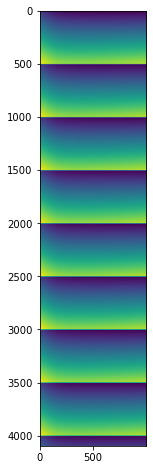

In [30]:
fig,ax = subplots(figsize=(8,8))
ax.imshow(result)

## Conclusion

Reading Bitshuffle-LZ4 data can be parallelized using multithreading in Python. 

The procedure is a bit tedious but not out of reach for a Python programmer: few threads and a couple of queues. 
This burden is worth when coupling decompression with azmuthal integration of the frame to reduce the amount of data to store in memory.

The performances obtained on a 64-core computer are close to what can be obtained from a GPU: 500 fps
The speed-up obtained with the procedure is 26x on a 64 core computer version single threaded implementation, which demonstrates multithreading is worth the burden.

Thanks again to the French-CRG for the computer.

In [31]:
print(f"Total processing time: {time.time()-start_time:.3f} s")

Total processing time: 337.419 s
